### Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
import shutil
import cv2

from matplotlib import cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing import image

### parameters

In [3]:
INPUT_DIR = '/content/drive/Shareddrives/MLFinal/data'
CITIES = os.listdir(INPUT_DIR)

In [4]:
print(f"Total number of cities is {len(os.listdir(INPUT_DIR))}\n")
for city in CITIES:
  PATH = f"{INPUT_DIR}/{city}/"
  print(f"Total number of {city} is {len(os.listdir(PATH))}")

Total number of cities is 4

Total number of taipei is 500
Total number of london is 500
Total number of washington is 500
Total number of bangkok is 500


### split data

In [5]:
SIZE_ = 299
W = 170
H = 125
SHAPE_2D = (SIZE_, SIZE_)
SHAPE_3D = (SIZE_, SIZE_, 3)

In [6]:
try:
  shutil.rmtree("/tmp/training")
  shutil.rmtree("/tmp/validation")
except:
  pass
try:
  os.mkdir("/tmp/training")
  os.mkdir("/tmp/validation")

except OSError:
  pass

In [7]:
SPLIT_SIZE = 0.8

# split into train and validation
def split_data(SOURCE, TRAINING, VALIDATION, SPLIT_SIZE):
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename, "is zero length, so ignoring!")
  
  shuffled_set = random.sample(files, len(files))
  N = int(SPLIT_SIZE*len(files))

  for i, filename in enumerate(shuffled_set):
    this_file = SOURCE + filename
    destination = lambda i: TRAINING + filename if (i<N) else VALIDATION + filename
    img_ = cv2.imread(this_file)
    #img = img_[H:H+SIZE_,W:W+SIZE_,:] # cut
    img = cv2.resize(img_, SHAPE_2D) # resize
    cv2.imwrite(destination(i), img)

In [8]:
for city in CITIES:
  SOURCE_DIR = f"{INPUT_DIR}/{city}/"
  TRAINING_DIR = f"/tmp/training/{city}/"
  VALIDATION_DIR = f"/tmp/validation/{city}/"

  # clean & make folder
  try:
    shutil.rmtree(TRAINING_DIR)
    shutil.rmtree(VALIDATION_DIR)
  except:
    pass
  try:
    os.mkdir(TRAINING_DIR)
    os.mkdir(VALIDATION_DIR)
  except:
    pass

  # split data & copy into folder
  split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE)

In [9]:
for city in CITIES:
  PATH_0 = f"/tmp/training/{city}/"
  PATH_1 = f"/tmp/validation/{city}/"
  print(f"Total number of training {city} is {len(os.listdir(PATH_0))}")
  print(f"Total number of validation {city} is {len(os.listdir(PATH_1))}")

Total number of training taipei is 400
Total number of validation taipei is 100
Total number of training london is 400
Total number of validation london is 100
Total number of training washington is 400
Total number of validation washington is 100
Total number of training bangkok is 400
Total number of validation bangkok is 100


### data preprocessing

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory("/tmp/training", target_size=SHAPE_2D, batch_size=32, class_mode="sparse")
validation_generator = validation_datagen.flow_from_directory("/tmp/validation", target_size=SHAPE_2D, batch_size=1, class_mode="sparse")

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


### pre-trained model
Xception: update version of InceptionV3

Reference:
- function: https://keras.io/api/applications/xception/
- paper: https://arxiv.org/abs/1610.02357

In [11]:
pre_trained_model = Xception(input_shape=SHAPE_3D, weights="imagenet", include_top=False)

for layer in pre_trained_model.layers:
  layer.trainable = False
#pre_trained_model.summary()

83683744/83683744 [==============================] - 3s 0us/step


In [12]:
x = tf.keras.layers.Flatten()(pre_trained_model.output)
x = tf.keras.layers.Dense(units=1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(CITIES), activation="softmax")(x)

model = Model(pre_trained_model.input, x)

#model.compile(loss="categorical_crossentropy", optimizer=RMSprop, metrics=["accuracy"])
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=1e-3), metrics=["sparse_categorical_accuracy"])

### model

In [13]:
history = model.fit(train_generator, steps_per_epoch=50, epochs=15, \
      validation_data=validation_generator)

Epoch 1/15
50/50 [==============================] - 36s 454ms/step - loss: 16.1428 - sparse_categorical_accuracy: 0.5825 - val_loss: 1.9816 - val_sparse_categorical_accuracy: 0.7200
Epoch 2/15
50/50 [==============================] - 26s 515ms/step - loss: 0.8304 - sparse_categorical_accuracy: 0.8275 - val_loss: 0.9440 - val_sparse_categorical_accuracy: 0.7600
Epoch 3/15
50/50 [==============================] - 22s 441ms/step - loss: 0.2414 - sparse_categorical_accuracy: 0.9156 - val_loss: 0.7782 - val_sparse_categorical_accuracy: 0.8000
Epoch 4/15
50/50 [==============================] - 26s 525ms/step - loss: 0.1046 - sparse_categorical_accuracy: 0.9638 - val_loss: 0.8470 - val_sparse_categorical_accuracy: 0.7975
Epoch 5/15
50/50 [==============================] - 27s 541ms/step - loss: 0.0991 - sparse_categorical_accuracy: 0.9675 - val_loss: 0.9061 - val_sparse_categorical_accuracy: 0.8200
Epoch 6/15
50/50 [==============================] - 26s 523ms/step - loss: 0.0684 - sparse_cat

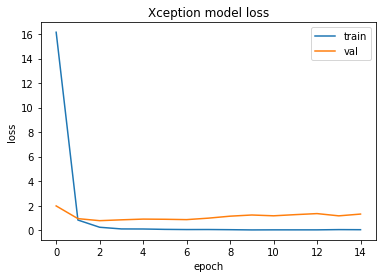

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Xception model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

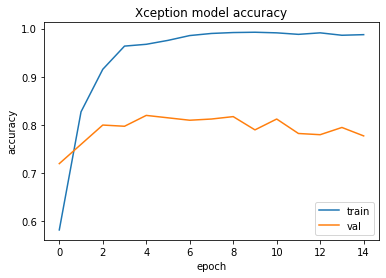

In [15]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Xception model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

## Grad-CAM
Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization

Reference:
- example: https://keras.io/examples/vision/grad_cam/
- paper: https://arxiv.org/abs/1610.02391

In [16]:
last_conv_layer_name = "block14_sepconv2_act" # depends on the model (use model.summary() to see)

In [17]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index):
  grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

  with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    class_channel = preds[:, pred_index]

  grads = tape.gradient(class_channel, last_conv_layer_output)
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)

  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

  heatmap = np.uint8(255 * heatmap.numpy())

  jet = cm.get_cmap("jet")
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  jet_heatmap = image.array_to_img(jet_heatmap).resize(SHAPE_2D)
  jet_heatmap = image.img_to_array(jet_heatmap)

  return jet_heatmap

### Prediction

In [18]:
from IPython.display import display
MAP = '/tmp/heatmap/'
try:
  shutil.rmtree(MAP)
except:
  pass
try:
  os.mkdir(MAP)
except:
  pass

In [19]:
class_map = train_generator.class_indices
classes = []
for key in class_map.keys():
  classes.append(key)

alpha = 0.8

def predict_image(filename, model, PRINT):
  img_ = image.load_img(filename, target_size=SHAPE_2D)
  img_array = image.img_to_array(img_)
  img_processed = np.expand_dims(img_array / 255., axis=0)

  prediction = model.predict(img_processed, verbose=0)
  index = np.argmax(prediction)

  if PRINT:
    heatmap = make_gradcam_heatmap(img_processed, model, last_conv_layer_name, index)

    # Superimpose the heatmap on original image
    vistualize_img = heatmap * alpha + img_array
    vistualize_img = image.array_to_img(vistualize_img)

    display(img_, vistualize_img)
  return str(classes[index])#, vistualize_img

In [20]:
print(class_map)

{'bangkok': 0, 'london': 1, 'taipei': 2, 'washington': 3}


In [22]:
PRINT = False
for city in classes:
  PATH0 = f"/tmp/training/{city}"
  d0 = {i:0 for i in classes}
  for x in os.listdir(PATH0):
    pred = predict_image(f"{PATH0}/{x}", model, PRINT)
    d0[pred] += 1

  PATH1 = f"/tmp/validation/{city}"
  d1 = {i:0 for i in classes}
  for x in os.listdir(PATH1):
    pred = predict_image(f"{PATH1}/{x}", model, PRINT)
    d1[pred] += 1
  
  d0 = dict(sorted(d0.items(), key=lambda i:i[1], reverse=True))
  d1 = dict(sorted(d1.items(), key=lambda i:i[1], reverse=True))
  print(f"training of {city}:", d0)
  print(f"validation of {city}:", d1)
  print(f"accuracy of {city}: {(d0[city])/400} / {(d1[city])/100} / {(d0[city]+d1[city])/500}\n")

training of bangkok: {'bangkok': 399, 'london': 1, 'taipei': 0, 'washington': 0}
validation of bangkok: {'bangkok': 84, 'london': 10, 'taipei': 3, 'washington': 3}
accuracy of bangkok: 0.9975 / 0.84 / 0.966

training of london: {'london': 400, 'bangkok': 0, 'taipei': 0, 'washington': 0}
validation of london: {'london': 87, 'washington': 6, 'taipei': 4, 'bangkok': 3}
accuracy of london: 1.0 / 0.87 / 0.974

training of taipei: {'taipei': 397, 'bangkok': 1, 'london': 1, 'washington': 1}
validation of taipei: {'taipei': 75, 'bangkok': 10, 'london': 10, 'washington': 5}
accuracy of taipei: 0.9925 / 0.75 / 0.944

training of washington: {'washington': 397, 'london': 2, 'bangkok': 1, 'taipei': 0}
validation of washington: {'washington': 65, 'london': 21, 'bangkok': 8, 'taipei': 6}
accuracy of washington: 0.9925 / 0.65 / 0.924



### Test

<ipython-input-17-570f78cd06b2>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


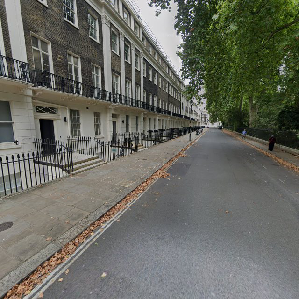

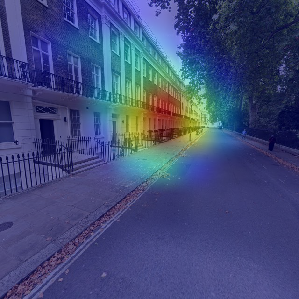

ground truth of london/3.jpg.jpg: london True


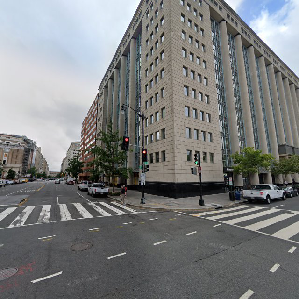

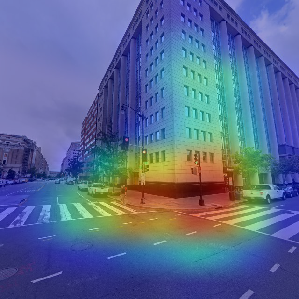

ground truth of washington/346.jpg.jpg: washington True


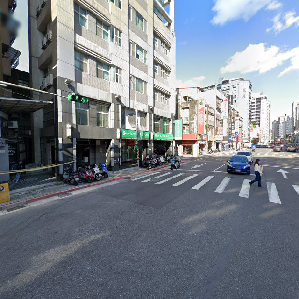

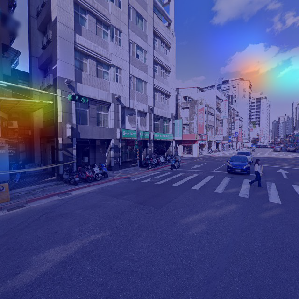

ground truth of taipei/326.jpg.jpg: taipei True


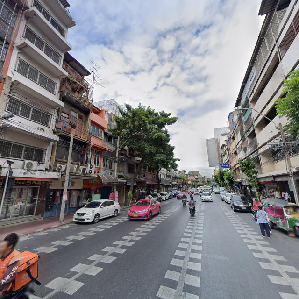

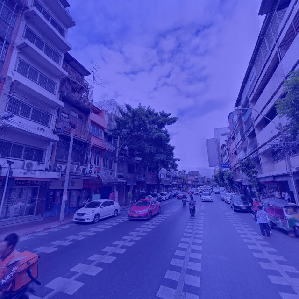

ground truth of bangkok/380.jpg.jpg: bangkok True


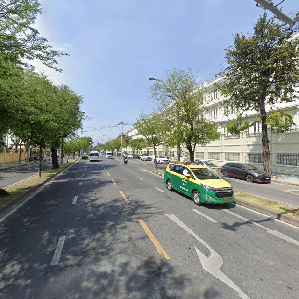

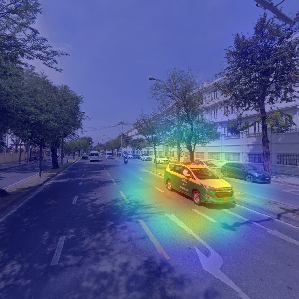

ground truth of bangkok/462.jpg.jpg: bangkok True
5/5


In [21]:
ans = 0
iter = 5

for i in range(iter):
  city = random.choice(classes)
  PATH = f"{INPUT_DIR}/{city}"
  x = random.choice(os.listdir(PATH))
  pred = predict_image(f"{PATH}/{x}", model, True)
  if city == pred: ans += 1
  print(f"ground truth of {city}/{x}.jpg: {city}", city == pred)

print(f"{ans}/{iter}")

### Check

In [24]:
PRINT = False
for city in classes:
  PATH0 = f"/tmp/training/{city}"
  for x in os.listdir(PATH0):
    pred = predict_image(f"{PATH0}/{x}", model, PRINT)
    if city != pred:
      print(f"{PATH0}/{x}: False, {pred}")

  PATH1 = f"/tmp/validation/{city}"
  d1 = {i:0 for i in classes}
  for x in os.listdir(PATH1):
    pred = predict_image(f"{PATH1}/{x}", model, PRINT)
    if city != pred:
      print(f"{PATH1}/{x}: False, {pred}")

/tmp/training/bangkok/30.jpg: False, london
/tmp/validation/bangkok/35.jpg: False, washington
/tmp/validation/bangkok/45.jpg: False, london
/tmp/validation/bangkok/370.jpg: False, london
/tmp/validation/bangkok/257.jpg: False, london
/tmp/validation/bangkok/240.jpg: False, taipei
/tmp/validation/bangkok/302.jpg: False, london
/tmp/validation/bangkok/291.jpg: False, london
/tmp/validation/bangkok/308.jpg: False, washington
/tmp/validation/bangkok/311.jpg: False, london
/tmp/validation/bangkok/150.jpg: False, washington
/tmp/validation/bangkok/92.jpg: False, taipei
/tmp/validation/bangkok/114.jpg: False, london
/tmp/validation/bangkok/22.jpg: False, london
/tmp/validation/bangkok/141.jpg: False, london
/tmp/validation/bangkok/101.jpg: False, london
/tmp/validation/bangkok/232.jpg: False, taipei
/tmp/validation/london/35.jpg: False, washington
/tmp/validation/london/433.jpg: False, washington
/tmp/validation/london/337.jpg: False, taipei
/tmp/validation/london/127.jpg: False, bangkok
/tmp